In [ ]:
!git clone https://github.com/amirhosein-mesbah/AMAlearn.git

Cloning into 'AMAlearn'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 33 (delta 2), reused 33 (delta 2), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [ ]:
!ls

AMAlearn  sample_data


In [ ]:
%cd '/content/AMAlearn/'

/content/AMAlearn


In [ ]:
!pwd

/content/AMAlearn


In [ ]:
!pip install -e .

Obtaining file:///content/AMAlearn
  Running setup.py develop for amalearn


In [ ]:
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.agent import RandomBanditAgent
from amalearn.reward import GaussianReward
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase
import numpy as np
import matplotlib.pyplot as plt
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.agent import RandomBanditAgent
from amalearn.reward import GaussianReward
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Reward(RewardBase):
    def __init__(self , price , volume ,beta1,beta2,use):
        super(Reward, self).__init__()

        self.price = price
        self.volume = volume
        #self.use = np.random.normal(61,5)
        self.use = use
        self.beta1 = beta1
        self.beta2 = beta2
    def get_reward(self):
        

        #beta1 = np.random.beta(4,3.5) #1/3
        #beta2 = np.random.beta(2,5) #2/3


        t = []

        t.append(np.argmin([price/volume*self.beta1 for price, volume in list(zip(self.price,self.volume))]))#index
        t.append(np.argmax([volume*self.beta2 for  volume in list(self.volume)]))#index
        action = np.random.choice(t, 1, p=[1/3, 2/3])[0]#value

        reward = self.price[action] + (100-self.use)*self.price[action]/100
        return reward 

In [ ]:
def optimal_mean(price , volume , beta1 , beta2 , use):

  #use = np.random.normal(61,5)

  #beta1 = np.random.beta(4,3.5) #1/3
  #beta2 = np.random.beta(2,5) #2/3
  
  m1 = []
  m2 = []

  b1 = np.argmin([price/volume*np.mean(beta1) for price, volume in list(zip(price,volume)) ]) #1/3 index
  b2 = np.argmax([v*np.mean(beta2) for  v in list(volume)]) #2/3 index
  r1 = price[b1]  + (100-use)*price[b1]/100
  r2 = price[b2]  + (100-use)*price[b2]/100
  r = r1*1/3 + r2*2/3
  return r

In [ ]:
use = np.random.normal(61,5)
beta1 = np.random.beta(4,3.5) #1/3
beta2 = np.random.beta(2,5) #2/3

rewards = []

price_1 = [21 , 35] 
volume_1 = [6 , 12] 
price_2 = [12, 22]
volume_2 = [3, 8]

rewards.append(Reward(price_1,volume_1,beta1,beta2,use))
rewards.append(Reward(price_2,volume_2,beta1,beta2,use))
rewards

[<__main__.Reward at 0x7f581e878750>, <__main__.Reward at 0x7f581e878690>]

In [ ]:
mean_reward = []
mean_reward.append(optimal_mean(price_1 , volume_1 , beta1 , beta2,use))
mean_reward.append(optimal_mean(price_2 , volume_2,beta1,beta2,use))
optimal_action = np.argmax(mean_reward)
max_reward = mean_reward[optimal_action]
print("optimal action" , optimal_action)
print("Max reward",max_reward)
print("rewards",mean_reward)

optimal action 0
Max reward 49.11081113958015
rewards [49.11081113958015, 30.86965271630752]


In [ ]:
class Agent_epsilonGreedy(AgentBase):
    def __init__(self, id, environment, eps, lr):
        super(Agent_epsilonGreedy, self).__init__(id, environment)
        
        self.lr = lr
        self.eps = eps
        self.available_actions = environment.available_actions()
        self.action_counts = [0 for i in range(self.available_actions)]
        self.QValues = [0 for i in range(self.available_actions)] 
    def select_action(self):

        policy = [np.argmax(self.QValues), np.random.randint(0, self.available_actions) ]
        action = np.random.choice(policy, 1, p=[(1-self.eps) , self.eps])
        return action[0]

    def update(self, action, r):

        self.action_counts[action] += 1
        self.QValues[action] = self.QValues[action] + self.lr * (r-self.QValues[action])

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, Ri, d, i = self.environment.step(action)
        self.update(action, Ri)
        #self.environment.render()
        return obs, Ri, d, i, action

In [ ]:
env = MutliArmedBanditEnvironment(rewards, 1000, '1')

In [ ]:
def eps_run(env ):

  mean_reward = []
  regret = []
  percent = []


  for epoch in range(10):
    reward = []
    q_action = [ 0 for i in range(2)]
    action_taken = [ 0 for i in range(2)]
    action_optimal_traial = [0 for _ in range(1000)]
    aa = []
    regret_h = []
    eps = 1
    agent = Agent_epsilonGreedy('1',env,eps,1)
    env.reset()
    for i in range(1000):
      _,r,_,_,a = agent.take_action()
      aa.append(a)
      if a == optimal_action:
        action_optimal_traial[i] = 1
      agent.lr = agent.lr/(i+1)
      agent.eps = agent.eps*0.9
      reward.append(r)
      q_action[a] =( q_action[a]*action_taken[a]+r)/(action_taken[a]+1)
      action_taken[a]+=1
      regret_h.append(sum([(max_reward-q_action[i])*action_taken[i] for i in range(2)])) 
    percent.append(action_optimal_traial)
    regret.append(regret_h)
    mean_reward.append(reward)
    print(reward)
    action = a
  return np.mean(mean_reward,axis = 0),action,regret , percent,aa

[49.11081113958014, 49.11081113958014, 30.86965271630752, 49.11081113958014, 30.86965271630752, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 30.86965271630752, 49.11081113958014, 30.86965271630752, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 30.86965271630752, 30.86965271630752, 30.86965271630752, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113

Text(0.5, 1.0, 'Average Reward per Trials - Epsilon_greedy Method')

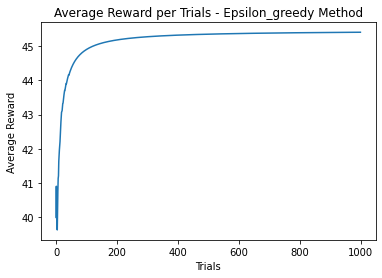

In [ ]:
d,converge_action,regret ,percent,aa= eps_run(env)
d = np.cumsum(d)
for i in range(len(d)):
  d[i] = d[i]/(i+1)
print("action" , converge_action)
print("reward" , max_reward)
plt.plot(d)
plt.ylabel('Average Reward')
plt.xlabel('Trials')
plt.title('Average Reward per Trials - Epsilon_greedy Method')

Text(0.5, 1.0, 'Regret per Trials - Reinforcment Comparison Agent')

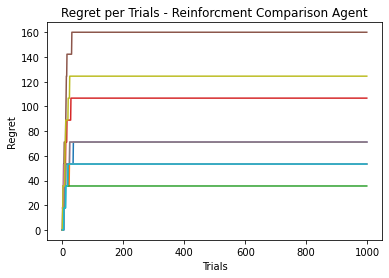

In [ ]:
for i in range(len(regret)):
  plt.plot(regret[i])
plt.ylabel('Regret')
plt.xlabel('Trials')
plt.title('Regret per Trials - Reinforcment Comparison Agent')

Text(0.5, 1.0, 'Mean Regret for 20 epoch')

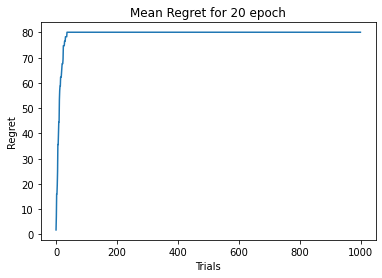

In [ ]:
plt.plot(np.mean(regret,axis = 0))
plt.ylabel('Regret')
plt.xlabel('Trials')
plt.title('Mean Regret for 20 epoch')

Text(0.5, 1.0, 'Mean Regret for 20 epoch')

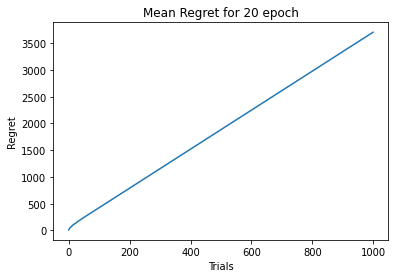

In [ ]:
plt.plot(np.mean(regret,axis = 0))
plt.ylabel('Regret')
plt.xlabel('Trials')
plt.title('Mean Regret for 20 epoch')

In [ ]:
w_size = 10
final_percent = []
for j in range(len(percent)):
  percent_optimal_action = []
  for i in range(len(percent[j])-w_size):
    percent_optimal_action.append(sum(percent[j][i:i+w_size])/(w_size))
  final_percent.append(percent_optimal_action)

Text(0.5, 1.0, 'epsilon greedy agent')

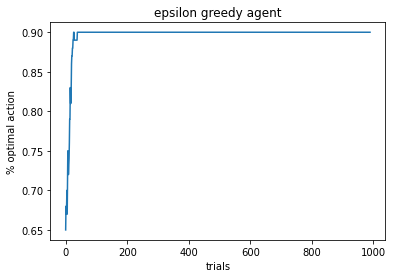

In [ ]:
plt.plot(np.mean(final_percent,axis =0))
#plt.plot(final_percent)
plt.xlabel('trials')
plt.ylabel('% optimal action')
plt.title('epsilon greedy agent')

In [ ]:
class Agent_UCB(AgentBase):
    def __init__(self, id, environment, delta):
        super(Agent_UCB, self).__init__(id, environment)
        self.rewards_means = []
        self.delta = delta
        self.available_actions = self.environment.available_actions()
        self.action_counts = [0 for i in range(self.available_actions)]
        self.C = 1
        self.lr = 1
        self.rewards_means = [1000 for _ in range(self.available_actions)]

    def select_action(self):

        UCB = []
        for i in range(self.available_actions):
            mean = self.rewards_means[i]
            ucb = self.rewards_means[i] + self.C * np.sqrt(2 * np.log(1 / self.delta) / self.action_counts[i])
            UCB.append(ucb)
       
        action = np.argmax(np.array(UCB))
        return action

    def update(self, action, r):
        self.action_counts[action] += 1
        self.lr = (1 / self.action_counts[action])
        self.rewards_means[action] = self.rewards_means[action] + self.lr* (r - self.rewards_means[action])

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, Ri, d, i = self.environment.step(action)
        self.update(action, Ri)
        #self.environment.render()
        return obs, Ri, d, i, action

In [ ]:
def ucb_run(env ):

  mean_reward = []
  regret = []
  percent = []


  for epoch in range(10):
    reward = []
    q_action = [ 0 for i in range(2)]
    action_taken = [ 0 for i in range(2)]
    action_optimal_traial = [0 for _ in range(1000)]
    aa = []
    regret_h = []
    eps = 1
    agent = Agent_UCB('2',env,1)
    env.reset()
    for i in range(1000):
      _,r,_,_,a = agent.take_action()
      aa.append(a)
      if a == optimal_action:
        action_optimal_traial[i] = 1
      #agent.lr = agent.lr/(i+1)
      #agent.eps = agent.eps*0.9
      reward.append(r)
      q_action[a] =( q_action[a]*action_taken[a]+r)/(action_taken[a]+1)
      action_taken[a]+=1
      regret_h.append(sum([(max_reward-q_action[i])*action_taken[i] for i in range(2)])) 
    percent.append(action_optimal_traial)
    regret.append(regret_h)
    mean_reward.append(reward)
    print(reward)
    action = a
  return np.mean(mean_reward,axis = 0),action,regret , percent,aa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


[49.11081113958014, 30.86965271630752, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113958014, 49.11081113

Text(0.5, 1.0, 'Average Reward per Trials - UCB Method')

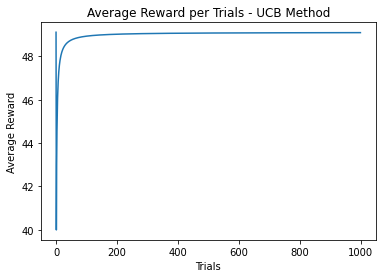

In [ ]:
d,converge_action,regret ,percent,aa= ucb_run(env)
d = np.cumsum(d)
for i in range(len(d)):
  d[i] = d[i]/(i+1)
print("action" , converge_action)
print("reward" , max_reward)
plt.plot(d)
plt.ylabel('Average Reward')
plt.xlabel('Trials')
plt.title('Average Reward per Trials - UCB Method')

Text(0.5, 1.0, 'Mean Regret for 10 epoch')

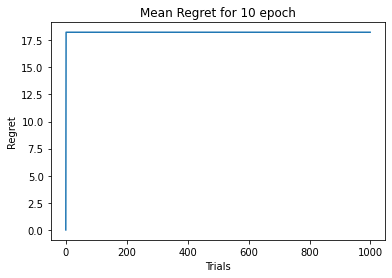

In [ ]:
plt.plot(np.mean(regret,axis = 0))
plt.ylabel('Regret')
plt.xlabel('Trials')
plt.title('Mean Regret for 10 epoch')

In [ ]:
w_size = 10
final_percent = []
for j in range(len(percent)):
  percent_optimal_action = []
  for i in range(len(percent[j])-w_size):
    percent_optimal_action.append(sum(percent[j][i:i+w_size])/(w_size))
  final_percent.append(percent_optimal_action)

Text(0.5, 1.0, 'UCB agent - percent of optimal action')

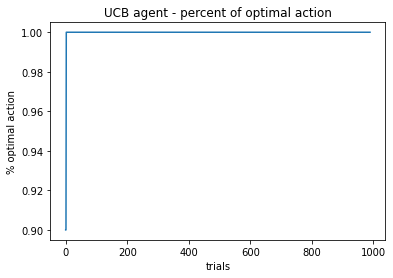

In [ ]:
plt.plot(np.mean(final_percent,axis =0))
#plt.plot(final_percent)
plt.xlabel('trials')
plt.ylabel('% optimal action')
plt.title('UCB agent - percent of optimal action')